# Limits of Diversification

In [1]:
import pandas as pd
import numpy as np
import edhc_risk_kit as erk
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline
%load_ext autoreload
%autoreload 2

With diversification, an investor attempts to create a portfolio that includes multiple investments in order to reduce risk. Consider, for example, an investment that consists of only stock issued by a single company. If that company's stock suffers a serious downturn, your portfolio will sustain the full brunt of the decline. By splitting your investment between the stocks from two different companies, you can reduce the potential risk to your portfolio.

Hedging can be thought of as insurance. When people decide to hedge, they are insuring themselves against a negative event. This doesn't prevent a negative event from happening, but if it does happen and you're properly hedged, the impact of the event is reduced. 

Portfolio managers, individual investors, and corporations use hedging techniques to reduce their exposure to various risks. In financial markets, however, hedging becomes more complicated than simply paying an insurance company a fee every year. Hedging against investment risk means strategically using instruments in the market to offset the risk of any adverse price movements. In other words, investors hedge one investment by making another. Technically, to hedge you would invest in two securities with negative correlations. 

In [2]:
ind_return = erk.get_ind_file('returns') # Get monthly industry returns
ind_size = erk.get_ind_file('size')      # Get market size of firms
ind_nfirms = erk.get_ind_file('nfirms')  # Get number of firms
print(ind_return.shape, ind_size.shape, ind_nfirms.shape)

(1110, 30) (1110, 30) (1110, 30)


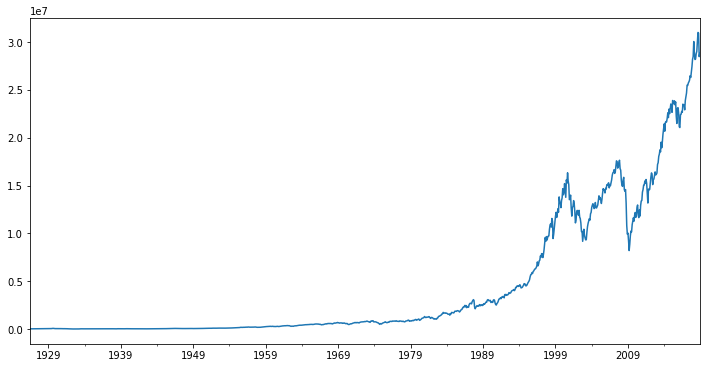

In [3]:
ind_mktcap = ind_nfirms * ind_size
total_mktcap = ind_mktcap.sum(axis='columns')
total_mktcap.plot(figsize=(12,6));

Clearly, the market has grown over time.

# Implementing a Cap-Weighted Portfolio

### The Capitalization-Weighted Index

A capitalization-weighted index is a type of market index with individual components, or securities, weighted according to their total market capitalization. Market capitalization uses the total market value of a firm's outstanding shares. The calculation multiples outstanding shares by the current price of a single share. The components with a higher market cap carry a higher weighting percentage in the index.  

One way to construct a market index is to build a portfolio whose weights are rebalanced back to the target weights every period. In reality, the weights may drift over time but this simplification is close enough.

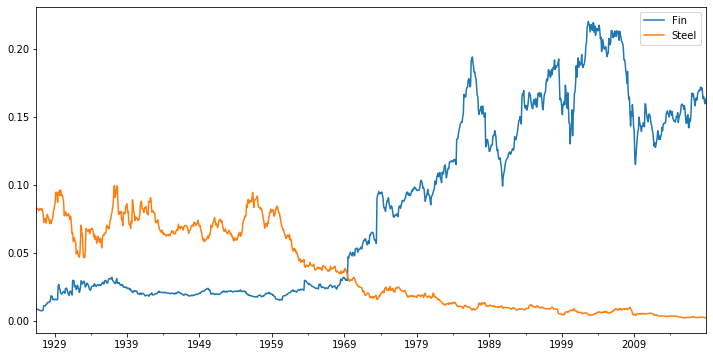

In [4]:
# Comparison of industries
ind_capweight = ind_mktcap.divide(total_mktcap, axis='rows')
ind_capweight[['Fin', 'Steel']].plot(figsize=(12,6));

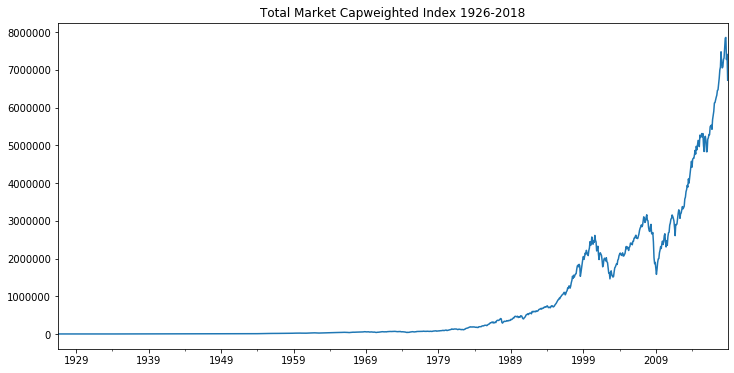

In [5]:
# Calculate total market return
total_market_return = (ind_capweight * ind_return).sum(axis='columns')
# Calculate market index
total_market_index = erk.drawdown(total_market_return).Wealth
total_market_index.plot(figsize=(12,6), title='Total Market Capweighted Index 1926-2018');

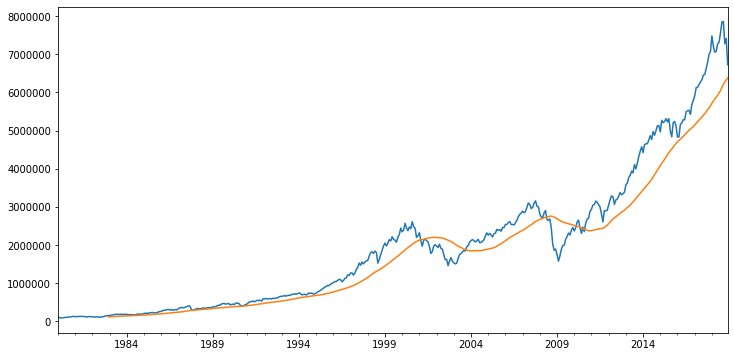

In [6]:
# Plot the index and a moving average
total_market_index['1980':].plot(figsize=(12,6))
total_market_index['1980':].rolling(window=36).mean().plot();

Let's create a time series of the annualized returns over the trailing 36 months and the average correlation across stocks over that same 36 months.

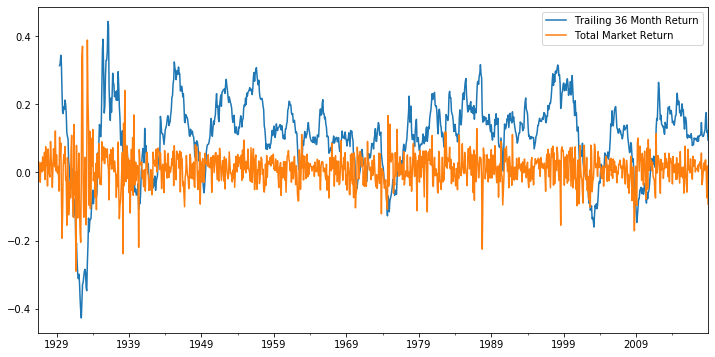

In [7]:
# Compute trailing 36 months returns
tmi_tr36rets = total_market_return.rolling(window=36).aggregate(erk.annualize_rets, periods_per_year=12)
tmi_tr36rets.plot(figsize=(12,6), label='Trailing 36 Month Return', legend=True);
total_market_return.plot(label='Total Market Return', legend=True);

Next we want to look at average correlations between all the industries over that same trailing 3 year window.

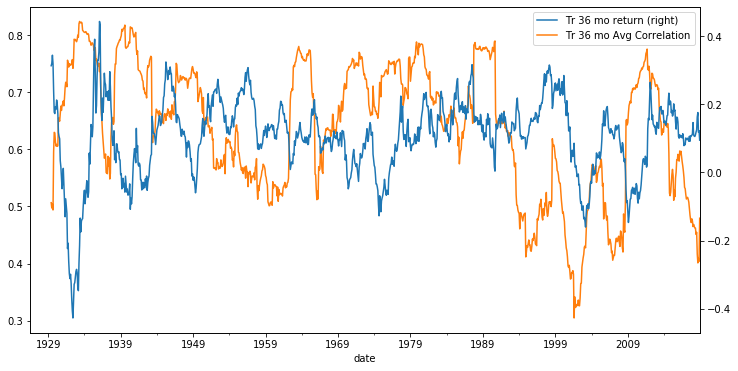

In [8]:
ts_corr = ind_return.rolling(window=36).corr()
ts_corr.index.names = ['date', 'industry']
ind_tr36corr = ts_corr.groupby(level='date').apply(lambda cormat: cormat.values.mean())
tmi_tr36rets.plot(secondary_y=True, legend=True, label="Tr 36 mo return", figsize=(12,6))
ind_tr36corr.plot(legend=True, label="Tr 36 mo Avg Correlation");

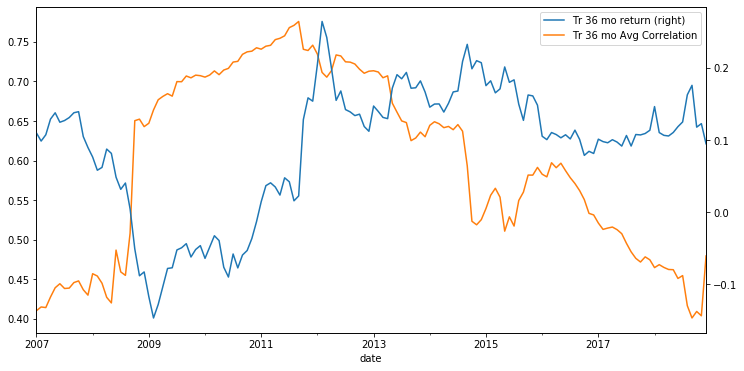

In [9]:
tmi_tr36rets['2007':].plot(secondary_y=True, legend=True, label="Tr 36 mo return", figsize=(12,6))
ind_tr36corr['2007':].plot(legend=True, label="Tr 36 mo Avg Correlation");

In [10]:
print(tmi_tr36rets.corr(ind_tr36corr)) # Correlation between returns and average correlation
print(tmi_tr36rets['2007':].corr(ind_tr36corr['2007':]))

-0.28010065062884126
-0.31456442187960876


Clearly, these two series are negatively correlated, which explains why diversification fails you when you need it most. When markets fall, correlations rise, making diversification much less valuable.

# Implementing Portfolio Insurance (CPPI) and Drawdown Constraints

Constant Proportion Portfolio Insurance (CPPI) is a type of portfolio insurance in which the investor sets a floor on the dollar value of their portfolio, then structures asset allocation around that decision. The two asset classes used in CPPI are a risky asset (usually equities or mutual funds) and a conservative asset of either cash, equivalents or treasury bonds. The percentage allocated to each depends on the "cushion" value, defined as current portfolio value minus floor value, and a multiplier coefficient, where a higher number denotes a more aggressive strategy.

In [11]:
# Load the industry returns and the total market index we previously created
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

The CPPI algorithm is surprisingly simple to implement. It takes as input the returns of a risky asset and a safe asset, the initial wealth to invest at the start, along with a floor that should not be violated.

In [12]:
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
# Assume the safe asset is paying 3% per year
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.values[:] = 0.03/12 # fast way to set all values to a number
start = 1000 # start at $1000
floor = 0.80 # set the floor to 80 percent of the starting value

Now, we need to backtest this strategy by starting at the beginning and at every point in time:

1. Compute the cushion (asset value minus floor)
2. Compute the allocation (based on the multiplier)
3. Compute the new asset value

The function `run_cppi` in the `edhec_risk toolkit` implements the following steps necessary to calculate the CPPI. Note that the floor is not updated at this point.

In [13]:
# set up the CPPI parameters
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3

## set up some DataFrames for saving intermediate values
account_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)

In [14]:
for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1 - risky_w
    risky_alloc = account_value * risky_w
    safe_alloc = account_value * safe_w
    # recompute the new account value at the end of this step
    account_value = risky_alloc * (1 + risky_r.iloc[step]) + safe_alloc * (1 + safe_r.iloc[step])
    # save the histories for analysis and plotting
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    risky_wealth = start * (1 + risky_r).cumprod()

Compare investment strategy with or without CPPI for different industries.

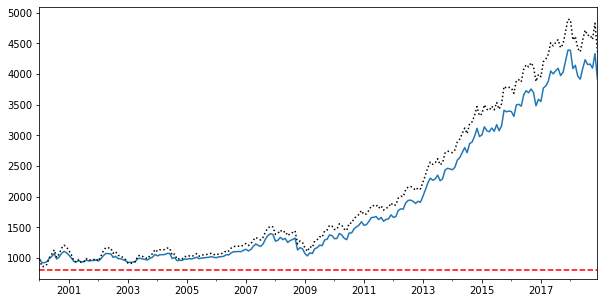

In [15]:
ind = "Beer"
ax = account_history[ind].plot(figsize=(10,5))
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--');

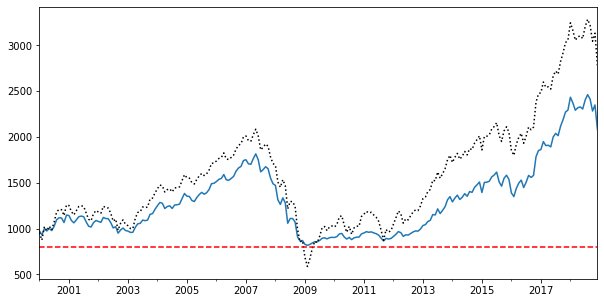

In [16]:
ind = "Fin"
ax = account_history[ind].plot(figsize=(10,5))
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--');

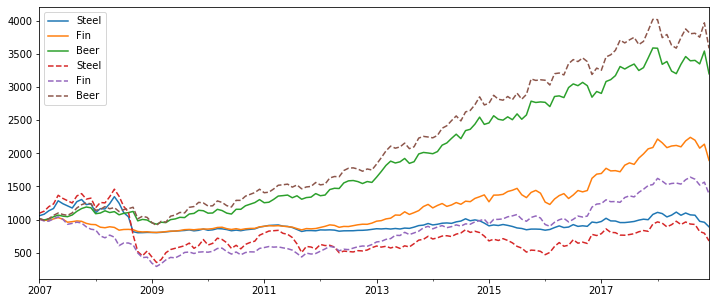

In [17]:
# Example
btr = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]])
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--");

The function `summary_stats` is a convenience function in the `edhic_risk_kit` which provides summary statistics on a set of returns.

In [18]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


Insurance strategies usually help with drawdowns, but they can also be adapted to explictly limit the drawdown.

## Explicitly Limiting Drawdowns

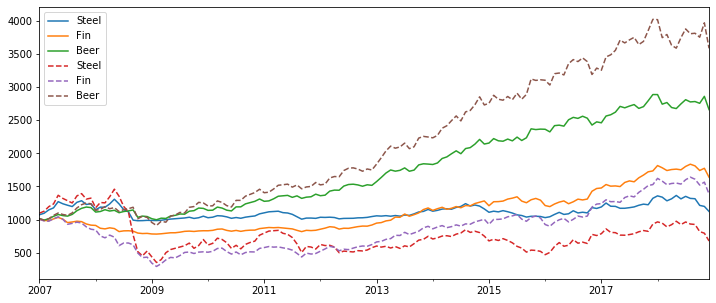

In [19]:
btr = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown=0.25)
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [20]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return",
                                                        "Annualized Vol",
                                                        "Sharpe Ratio",
                                                        "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.262958,-0.248059
Fin,0.041975,0.085028,0.136964,-0.243626
Beer,0.084375,0.086263,0.613413,-0.161186


# Random Walk Generation

The stochastic model for asset returns is given by the Geometric Brownian Motion (GBM) process:

$$ \frac{S_{t+dt}-S_t}{S_t} = \mu dt + \sigma\sqrt{dt}\xi_t $$

When we generate simulated returns, we can usually ignore the decomposition of $\mu$ since we only care about the net effective drift term without worrying about what the components of it are. The function `gbm` in the `edhc_risk_kit` implements the GBM process. The function takes as inputs the number of years you want to generate returns and the number of scenarios as well as the parameters for the model, i.e., $\mu$, $\sigma$, the step size (e.g., per year) and the initial stock price.

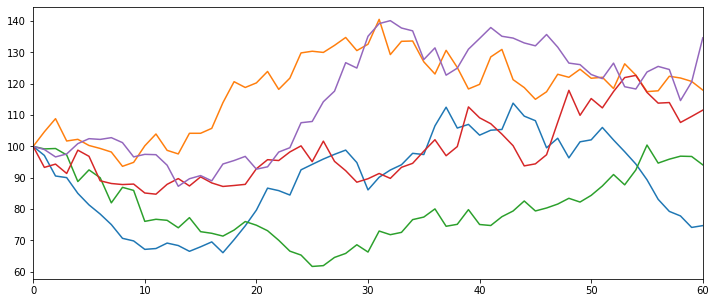

In [21]:
# Example
erk.gbm(n_years=5, n_scenarios=5, mu=0.07).plot(figsize=(12,5), legend=False);

In [22]:
def show_gbm(n_scenarios, mu, sigma):
    """
    Draw the results of a stock price evolution under a Geometric Brownian Motion model
    """
    s_0=100
    prices = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, s_0=s_0)
    ax = prices.plot(legend=False, color="indianred", alpha = 0.5, linewidth=2, figsize=(12,5))
    ax.axhline(y=100, ls=":", color="black")
    # draw a dot at the origin
    ax.plot(0,s_0, marker='o',color='darkred', alpha=0.2)

In [23]:
gbm_controls = widgets.interactive(show_gbm, 
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=1, value=1), 
                                   mu=(0., +.2,.01),
                                   sigma=(0, .3, .01))
display(gbm_controls)

interactive(children=(IntSlider(value=1, description='n_scenarios', max=1000, min=1), FloatSlider(value=0.1, d…

# Interactive Plotting and Monte Carlo Simulations of CPPI

In [24]:
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]
    y_max=wealth.values.max()*y_max/100
    ax = wealth.plot(legend=False, alpha=0.3, color="indianred", figsize=(12, 6))
    ax.axhline(y=start, ls=":", color="black")
    ax.axhline(y=start*floor, ls="--", color="red")
    ax.set_ylim(top=y_max)

cppi_controls = widgets.interactive(show_cppi, 
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50), 
                                   mu=(0., +.2, .01),
                                   sigma=(0, .30, .05),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis"))
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

# Adding a Histogram and Reporting Floor Violations

In [25]:
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]
    # calculate terminal wealth stats
    y_max=wealth.values.max()*y_max/100
    terminal_wealth = wealth.iloc[-1]
    # Plot!
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.subplots_adjust(wspace=0.0)
    
    wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")

cppi_controls = widgets.interactive(show_cppi, 
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50), 
                                   mu=(0., +.2, .01),
                                   sigma=(0, .3, .05),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis")
)
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

# Adding Terminal Wealth Statistics

In [26]:
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0., riskfree_rate=0.03, steps_per_year=12, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=steps_per_year)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r),riskfree_rate=riskfree_rate,m=m, start=start, floor=floor)
    wealth = btr["Wealth"]

    # calculate terminal wealth stats
    y_max=wealth.values.max()*y_max/100
    terminal_wealth = wealth.iloc[-1]
    
    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    failure_mask = np.less(terminal_wealth, start*floor)
    n_failures = failure_mask.sum()
    p_fail = n_failures/n_scenarios

    e_shortfall = np.dot(tv-start*floor, failure_mask)/n_failures if n_failures > 0 else 0.0

    # Plot!
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios':[3,2]}, figsize=(24, 9))
    plt.subplots_adjust(wspace=0.0)
    
    wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=tw_mean, ls=":", color="blue")
    hist_ax.axhline(y=tw_median, ls=":", color="purple")
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.7, .9),xycoords='axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.7, .85),xycoords='axes fraction', fontsize=24)
    if (floor > 0.01):
        hist_ax.axhline(y=start*floor, ls="--", color="red", linewidth=3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(shortfall)=${e_shortfall:2.2f}", xy=(.7, .7), xycoords='axes fraction', fontsize=24)

cppi_controls = widgets.interactive(show_cppi,
                                   n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50), 
                                   mu=(0., +.2, .01),
                                   sigma=(0, .3, .05),
                                   floor=(0, 2, .1),
                                   m=(1, 5, .5),
                                   riskfree_rate=(0, .05, .01),
                                   steps_per_year=widgets.IntSlider(min=1, max=12, step=1, value=12,
                                                          description="Rebals/Year"),
                                   y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                          description="Zoom Y Axis")
)
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…